<a href="https://colab.research.google.com/github/mannixp/CHIST/blob/main/PDF_Construction_using_extruded_mesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get update --fix-missing

try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

**Example 3 - Available potential energy (APE)**

The available potential energy (APE) of a buoyancy field $B(\mathbf{x})$ of vertical extent $Z(\mathbf{x})$ is given by the difference of its actual potential energy and the (minimal) potential energy 
\begin{equation}
\mathbb{E}[BZ^*]  - \mathbb{E}[BZ] = \iint b \left(Z^*(b) -z \right) \; f_{BZ}(b,z) \; dbdz,
\end{equation}
where the reference state
\begin{equation}
Z^*(b) = F^{-1}_Z \circ F_B(b) = Q_Z \circ F_B(b),
\end{equation}
corresponds to an adiabatic volume preserving rearrangement of the fluid into a state that minimises PE. To calculate this quantity therefore requires an estimation of the buoyancy's PDF $f_B$, CDF $F_B$ as well as the vertical cordinate's QDF $Q_Z = F_Z^{-1}$. In addition to these objects the APE calculation also requires the composition of functions. In this example we demonstrate two additional features of our method: (1) *calcuating the inverse of the CDF* and (2) *composing functions*.

As an example of a buoyancy field and potential we will consider
\begin{align}
    B(x_1,x_2) &= 4x_2(1 - x_2),\\
    Z(x_1,x_2) &= x_2,
\end{align}
such that the physical domain is given by $\Omega_X \in [-1,1] \times [0,1]$, the buoyancy domain $\Omega_B \in [0,1]$ and that of the potential by $\Omega_Z \in [0,1]$. 

To construct the buoyancy's PDF & CDF $f_B,F_B$ and the vertical cordinate's QDF $F_Z^{-1}$ we make use of the **Ptp** class as well as [firedrake](https://www.firedrakeproject.org/) (which is required to evaluate integrals) both of which are imported below.

In [1]:
from numdf import Ptp
from firedrake import *

We first initialise a Ptp object by prescribing the domain $\Omega_X$, range $\Omega_Y$ and the number of finite elements/bins we will use.

In [2]:
ptp = Ptp(Omega_X={'x1': (-1, 1), 'x2': (0, 1)}, Omega_Y={'Y': (0, 1)}, n_elements=50)

We then grab the coordinate functions and write our fields $B$ and $Z$ in terms of these

In [3]:
x1, x2 = ptp.x_coords()
B = 4*x2*(1-x2)
Z = x2

For each of these fields we have just created we now create their associated density objects by calling the fit method. Note that as we have used a small number of elements and a relatively small quadrature degree the fit method issues a warning. In this case one must increase both the number of elements and the quarature degree, which increases the run time of **fit()**, in order to remove this. 

In [4]:
density_B = ptp.fit(Y=B, quadrature_degree=500)
density_Z = ptp.fit(Y=Z, quadrature_degree=250)

Plotting their respective cdf's below we can confirm that two distinct density objects have been created.

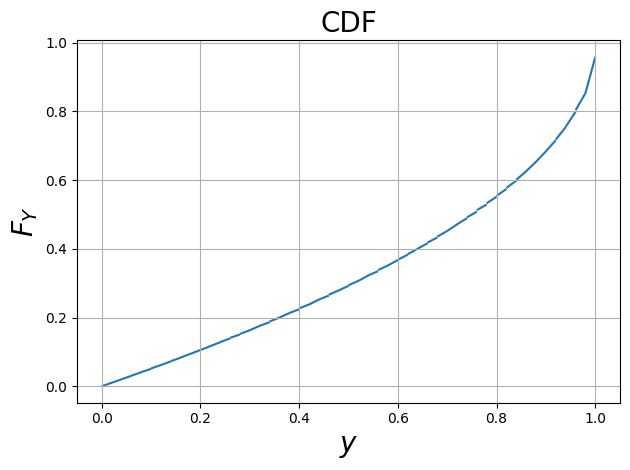

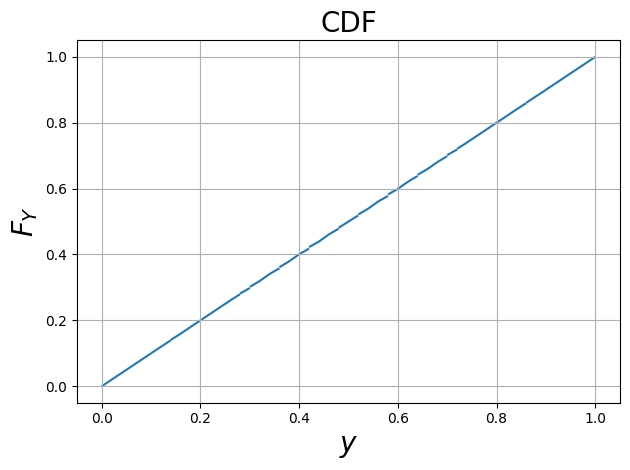

In [5]:
density_B.plot('CDF')
density_Z.plot('CDF')


To obtain the reference height $Z^*(b)$ we evaluate the function composition $Z^*(b) = Q_Z \circ F_B(b)$, at a number of quadrature points, using the compose method associated with the density class

In [6]:
Q_Z = density_Z.cdf
F_B = density_B.cdf
Z_star = density_B.compose(Q_Z, F_B, quadrature_degree=200)
# Z_star = density_Z.compose(Q_Z, F_B, quadrature_degree=100)  # equivalent code

Whilst the quadrature scheme is decided automatically we can increase the number of quadrature points used when evaluating the function composition above by increasing the quadrature degree.

To evaluate the background potential energy (bpe) we integrate the expression
\begin{equation}
\mathbb{E}[BZ^*] = \int b Z^*(b) f_{B}(b) \; db,
\end{equation}
by using the inbuilt firedrake method *assemble()* to which we must pass the same quadrature degree as was used when evaluating the function composition.

In [7]:
b = density_B.y
f_B = density_B.pdf
bpe = assemble( b*Z_star*f_B*dx(degree=200) )

To calculate the total potential energy (tpe) we evaluate the integral
\begin{equation}
\mathbb{E}[BZ] = -\frac{1}{V}\int B(X) Z(X) dX, 
\end{equation}
by integrating over $\Omega_X$.

In [8]:
V = 2  # size of the domain
tpe = -(1/V)*assemble( Z*B*dx )

The available potential energy is then given by 

In [9]:
ape = bpe + tpe
print('ape = %f \n' % ape)

ape = 0.041536 



Repeating this calculation with $B = 1-x_2$, i.e. the conductive state of Rayleigh-Benard convection which has $ape = 1/6$ we can verify our calculation. 